## Load model

In [1]:
# Load model
import os
script_path = os.getcwd()
from cobra.io import read_sbml_model, write_sbml_model
#path = 'Chlamy_model_iCre1355-master/iCre1355_SBML_Matlab_files/iCre1355_auto.xml'
path_sbml3fbc = 'iCre1355_auto_fbc.xml'
#model = read_sbml_model(path)
#write_sbml_model(model, path_sbml3fbc)  # stores as SBML3 + fbc
model = read_sbml_model(os.path.join(script_path, path_sbml3fbc))  # magic, no warnings

# NOTE: I had to re-write the model because it gave me A LOT of warnings and made everything go super slow.

No objective coefficients in model. Unclear what should be optimized


In [2]:
model

Name,iCre1355
Memory address,7fb22f465700
Number of metabolites,1845
Number of reactions,2394
Number of genes,1963
Number of groups,117
Objective expression,0
Compartments,"Cytosol, Chloroplast, Mitochondria, Glyoxysome, Flagellum, Extra-organism, Nucleus, Golgi Apparatus, Eyespot, Thylakoid Lumen, Inner Mitochondrial membrane space"


## Memote assessment

In [3]:
# Assess model with memote

#!memote report snapshot --filename "iCre1355_auto_fbc.html" "/Users/ericbf10/Library/CloudStorage/GoogleDrive-ericbaufa10@gmail.com/My Drive/PERSONAL/DTU/DTU - Bioinformatics and Systems Biology/2022_Autumn_Semester/27410_Computer-Aided_Cell_Factory_Design/Project/iCre1355_auto_fbc.xml"

In [4]:
#!memote report snapshot --filename "iRC1080.html" "/Users/ericbf10/Library/CloudStorage/GoogleDrive-ericbaufa10@gmail.com/My Drive/PERSONAL/DTU/DTU - Bioinformatics and Systems Biology/2022_Autumn_Semester/27410_Computer-Aided_Cell_Factory_Design/Project/iRC1080.xml"

## Explore model & create S matrix

In [5]:
# Explore the model

print("The model has %d reactions, %d metabolites and %d genes" % (len(model.reactions), len(model.metabolites), len(model.genes)))

The model has 2394 reactions, 1845 metabolites and 1963 genes


In [6]:
# Create the stoichiometric matrix

from cobra.util import create_stoichiometric_matrix
S = create_stoichiometric_matrix(model)
print(S)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [7]:
# Check non-zero elements of S

import numpy as np
non_zero_elem = np.count_nonzero(S)
zero_elem = np.count_nonzero(S==0)
print("The percentage of non-zero elements in S is:", str(non_zero_elem/(zero_elem + non_zero_elem)*100) + "%")

The percentage of non-zero elements in S is: 0.2494492781185122%


In [8]:
for reaction in model.reactions.query('Biomass', 'name'):
    print(reaction.id)

Biomass_Chlamy_auto
Biomass_Chlamy_mixo
Biomass_Chlamy_hetero


In [9]:
# Add objective function

model.objective = 'Biomass_Chlamy_auto'

In [10]:
# Simulate the model

solution = model.optimize()
solution

,fluxes,reduced_costs
AAT,0.000011,0.000000e+00
ALATLm,0.000000,0.000000e+00
ASNTLm,0.000000,0.000000e+00
ASPO,0.000000,-1.110223e-16
ASPOm,0.000000,-1.110223e-16
...,...,...
PYDXPP,0.000000,0.000000e+00
PYDXS,0.000000,0.000000e+00
Biomass_Chlamy_auto,0.051575,-2.657596e-15
Biomass_Chlamy_mixo,0.000000,-2.020611e+00


## Change medium

In [11]:
# Change medium composition (add 17.5 mM of acetate, remove photons)

medium = model.medium
medium['EX_ac_e'] = 17.5
medium['EX_photonVis_e'] = 0.
model.medium = medium
model.medium

{'EX_h_e': 10.0,
 'EX_h2o_e': 10.0,
 'EX_pi_e': 10.0,
 'EX_nh4_e': 1.0,
 'EX_so4_e': 10.0,
 'EX_fe2_e': 10.0,
 'EX_mg2_e': 10.0,
 'EX_na1_e': 10.0,
 'EX_o2_e': 10.0,
 'EX_co2_e': 2.0,
 'EX_ac_e': 17.5}

## Add heterologous mets and rxns

In [12]:
# Add heterologous metabolites and reactions

from cobra import Reaction, Metabolite

### Create metabolite ###
metabolite1 = Metabolite('jet_juice_c')
metabolite1.name = 'Jet Juice'
metabolite1.formula = 'C29H38O2'
metabolite1.compartment = 'c'
model.add_metabolites([metabolite1])

### Define production of jet fuel reaction ###
reaction1 = Reaction('jet_fuel')
reaction1.name = 'iPKS'
reaction1.lower_bound = 0.  # This makes the reaction irreversible
reaction1.upper_bound = 1000.  # This is the default ub

# Add metabolites to the reaction
reaction1.add_metabolites({
    model.metabolites.get_by_id("ac_c"): -11.0,
    model.metabolites.get_by_id("nadp_c"): 11.0,
    model.metabolites.get_by_id("amet_c"): -7.0,
    model.metabolites.get_by_id("ahcys_c"): 7.0,
    model.metabolites.get_by_id("nadph_c"): -11.0,
    model.metabolites.get_by_id("h_c"): 11.0,
    model.metabolites.get_by_id("jet_juice_c"): 1.0
})

### Define jet fuel exchange reaction ###
reaction2 = Reaction('EX_jet_fuel')
reaction2.name = 'Jet Fuel exchange'
reaction2.lower_bound = 0.  # This makes the reaction irreversible
reaction2.upper_bound = 1000.  # This is the default ub

# Add metabolites to the reaction
reaction2.add_metabolites({
    model.metabolites.get_by_id("jet_juice_c"): -1.0
})

model.add_reactions([reaction1, reaction2])

print(reaction1.reaction)
print(reaction2.reaction)

11.0 ac_c + 7.0 amet_c + 11.0 nadph_c --> 7.0 ahcys_c + 11.0 h_c + jet_juice_c + 11.0 nadp_c
jet_juice_c --> 


## Set model objective and get max theoretical yield

In [13]:
# Add objective function

model.objective = 'jet_fuel'

In [14]:
# Simulate the model and get max theoretical yield of jet fuel

solution = model.optimize()
solution

,fluxes,reduced_costs
AAT,1.325479,0.000000e+00
ALATLm,0.000000,0.000000e+00
ASNTLm,0.000000,0.000000e+00
ASPO,0.000000,-1.235608e-02
ASPOm,0.000000,-1.235608e-02
...,...,...
Biomass_Chlamy_auto,0.000000,-2.404374e+00
Biomass_Chlamy_mixo,0.000000,-2.368909e+00
Biomass_Chlamy_hetero,0.000000,-9.815728e-01
jet_fuel,0.781719,-8.881784e-16


In [15]:
# Check what is the minimal medium to grow C.reinhardtii with acetate

from cobra.medium import minimal_medium

max_fuel = model.slim_optimize()
print("The maximum theoretical jet fuel yield we can produce in these conditions is", max_fuel)
minimal_medium(model, max_fuel)

The maximum theoretical jet fuel yield we can produce in these conditions is 0.7817186183656002


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/cobra/medium/minimal_medium.py:112: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  medium = pd.Series()


EX_na1_e     2.824684
EX_o2_e      5.294693
EX_ac_e     17.500000
dtype: float64

In [16]:
# Get molar yield (mol jet fuel / mol acetate)

solution.fluxes['EX_jet_fuel'] / (-1. * solution.fluxes['EX_ac_e'])

0.044669635335177156

## Plot phenotypic phase planes

In [17]:
from cobra.flux_analysis.phenotype_phase_plane import production_envelope

In [18]:
ppp_ac = production_envelope(model,
                    reactions=[model.reactions.EX_ac_e],
                    objective=model.reactions.jet_fuel)

In [19]:
# Phenotypic phase plane (ppp) of acetate

ppp_ac

,carbon_source,flux_minimum,carbon_yield_minimum,mass_yield_minimum,flux_maximum,carbon_yield_maximum,mass_yield_maximum,EX_ac_e
0,EX_ac_e,0.0,0.0,NaN,0.781719,7.995865,NaN,-17.500000
1,EX_ac_e,0.0,0.0,NaN,0.742547,7.988239,NaN,-16.638947
2,EX_ac_e,0.0,0.0,NaN,0.703343,7.979418,NaN,-15.777895
3,EX_ac_e,0.0,0.0,NaN,0.663999,7.967894,NaN,-14.916842
4,EX_ac_e,0.0,0.0,NaN,0.624655,7.954957,NaN,-14.055789
5,EX_ac_e,0.0,0.0,NaN,0.585311,7.940333,NaN,-13.194737
6,EX_ac_e,0.0,0.0,NaN,0.545966,7.923666,NaN,-12.333684
7,EX_ac_e,0.0,0.0,NaN,0.506622,7.904497,NaN,-11.472632
8,EX_ac_e,0.0,0.0,NaN,0.467278,7.882218,NaN,-10.611579
9,EX_ac_e,0.0,0.0,NaN,0.427552,7.848996,NaN,-9.750526


/var/folders/5p/3vntk1ms267_zxphn5yv54mm0000gn/T/ipykernel_59691/1752839450.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


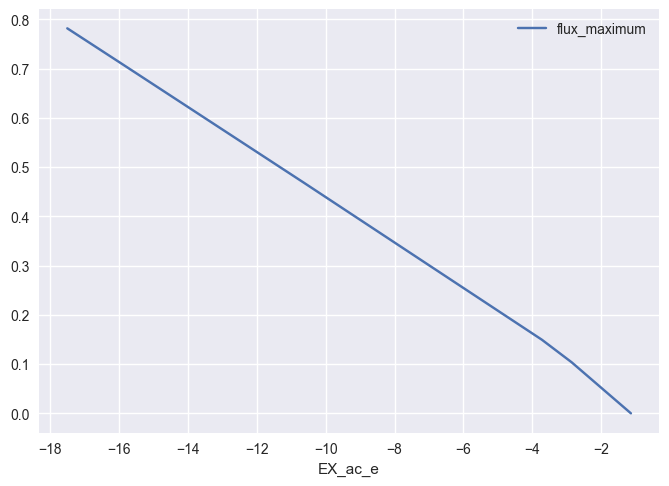

In [20]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline

ppp_ac.plot(x='EX_ac_e', y='flux_maximum');

In [21]:
# Phenotypic phase plane (ppp) of acetate (aerobic vs anaerobic)

ppp_ac_3D = production_envelope(model, reactions=[model.reactions.EX_ac_e, model.reactions.EX_o2_e],
                                   objective=model.reactions.jet_fuel, points=50)

In [22]:
import pandas
pandas.options.display.max_rows = 12
ppp_ac_3D

,carbon_source,flux_minimum,carbon_yield_minimum,mass_yield_minimum,flux_maximum,carbon_yield_maximum,mass_yield_maximum,EX_ac_e,EX_o2_e
0,EX_ac_e,0.0,0.0,NaN,0.744235,7.612463,NaN,-17.50,-10.000000
1,EX_ac_e,0.0,0.0,NaN,0.746118,7.631717,NaN,-17.50,-9.795918
2,EX_ac_e,0.0,0.0,NaN,0.747889,7.649841,NaN,-17.50,-9.591837
3,EX_ac_e,0.0,0.0,NaN,0.749496,7.666275,NaN,-17.50,-9.387755
4,EX_ac_e,0.0,0.0,NaN,0.751103,7.682708,NaN,-17.50,-9.183673
...,...,...,...,...,...,...,...,...,...
2495,EX_ac_e,0.0,0.0,NaN,0.000000,0.000000,NaN,-1.14,-0.816327
2496,EX_ac_e,NaN,NaN,NaN,NaN,NaN,NaN,-1.14,-0.612245
2497,EX_ac_e,NaN,NaN,NaN,NaN,NaN,NaN,-1.14,-0.408163
2498,EX_ac_e,NaN,NaN,NaN,NaN,NaN,NaN,-1.14,-0.204082


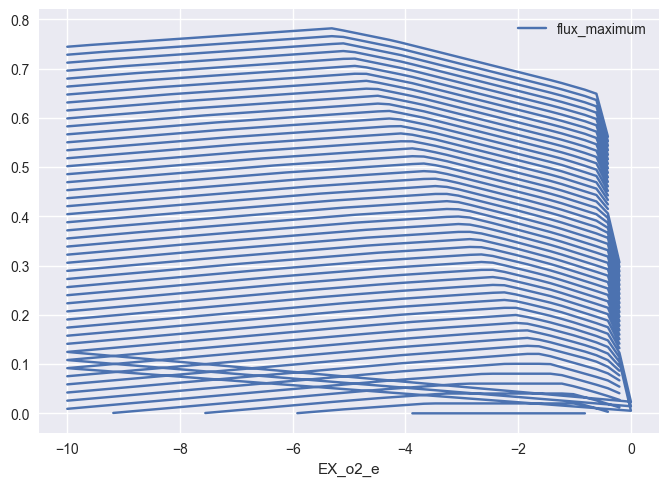

In [23]:
ppp_ac_3D.plot(x='EX_o2_e', y='flux_maximum');

# Explanation: As the concentration of acetate decreases in the medium, the flux maximum (y axis)
# of jet fuel is reduced (as expected). There is something surprising in the graph, because
# when [Acetate] decreases, less oxygen allows to increase the flux_maximum until a certain point,
# where the oxygen levels are too low and the production of jet fuel decreases again.

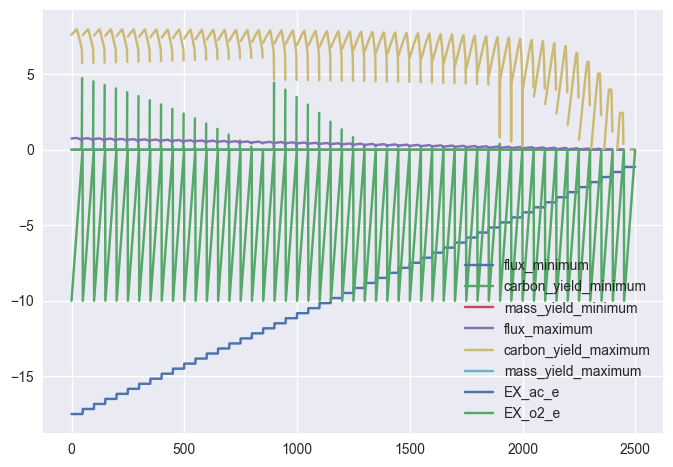

In [31]:
ppp_ac_3D.plot();

# Explanation: WTF is this?

In [27]:
from cameo.flux_analysis import phenotypic_phase_plane
from cameo.visualization.plotting.with_plotly import PlotlyPlotter
plotter = PlotlyPlotter()

In [29]:
ppp_ac_3D = phenotypic_phase_plane(model, variables=[model.reactions.EX_ac_e, model.reactions.EX_o2_e],
                                   objective=model.reactions.jet_fuel, points=50)

In [30]:
ppp_ac_3D.data_frame

,EX_ac_e,EX_o2_e,objective_lower_bound,objective_upper_bound,c_yield_lower_bound,c_yield_upper_bound,mass_yield_lower_bound,mass_yield_upper_bound
0,-17.50,-10.000000,0.0,0.744235,0.0,7.612463,NaN,NaN
1,-17.50,-9.795918,0.0,0.746118,0.0,7.631717,NaN,NaN
2,-17.50,-9.591837,0.0,0.747889,0.0,7.649841,NaN,NaN
3,-17.50,-9.387755,0.0,0.749496,0.0,7.666275,NaN,NaN
4,-17.50,-9.183673,0.0,0.751103,0.0,7.682708,NaN,NaN
...,...,...,...,...,...,...,...,...
2495,-1.14,-0.816327,0.0,0.000000,0.0,0.000000,NaN,NaN
2496,-1.14,-0.612245,NaN,NaN,NaN,NaN,NaN,NaN
2497,-1.14,-0.408163,NaN,NaN,NaN,NaN,NaN,NaN
2498,-1.14,-0.204082,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
import warnings
warnings.filterwarnings('ignore')
ppp_ac_3D.plot(plotter)

AttributeError: 'DataFrame' object has no attribute 'as_matrix'

## Compute Gene knockout strategies (not done due to Error)

In [63]:
# See what genes are essential in our model

import matplotlib.pyplot as plt
plt.style.use('ggplot')
from pandas import DataFrame
from cobra.io import read_sbml_model
%matplotlib inline

In [64]:
essentiality = {}
for gene in model.genes:
    with model:
        gene.knock_out()
        essentiality[gene] = model.slim_optimize(error_value=0.)

In [3]:
essentiality[:10]

NameError: name 'essentiality' is not defined

In [70]:
df = DataFrame.from_dict(essentiality, orient='index')
df = df.rename(columns={0: 'jet_fuel'})
df = df.sort_values('jet_fuel')

<AxesSubplot: ylabel='Frequency'>

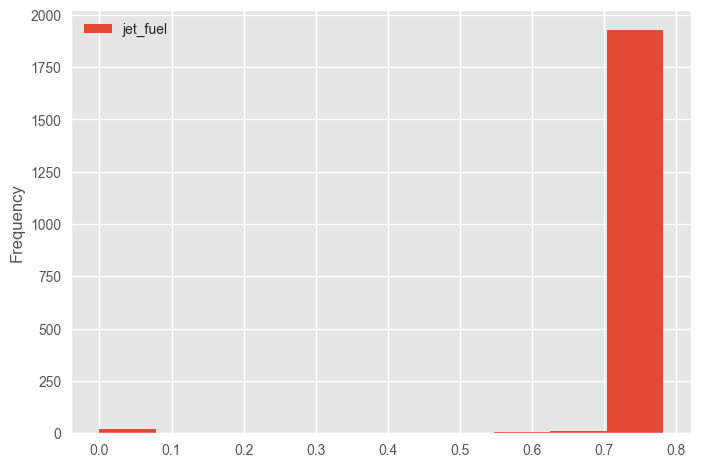

In [71]:
df.plot.hist()

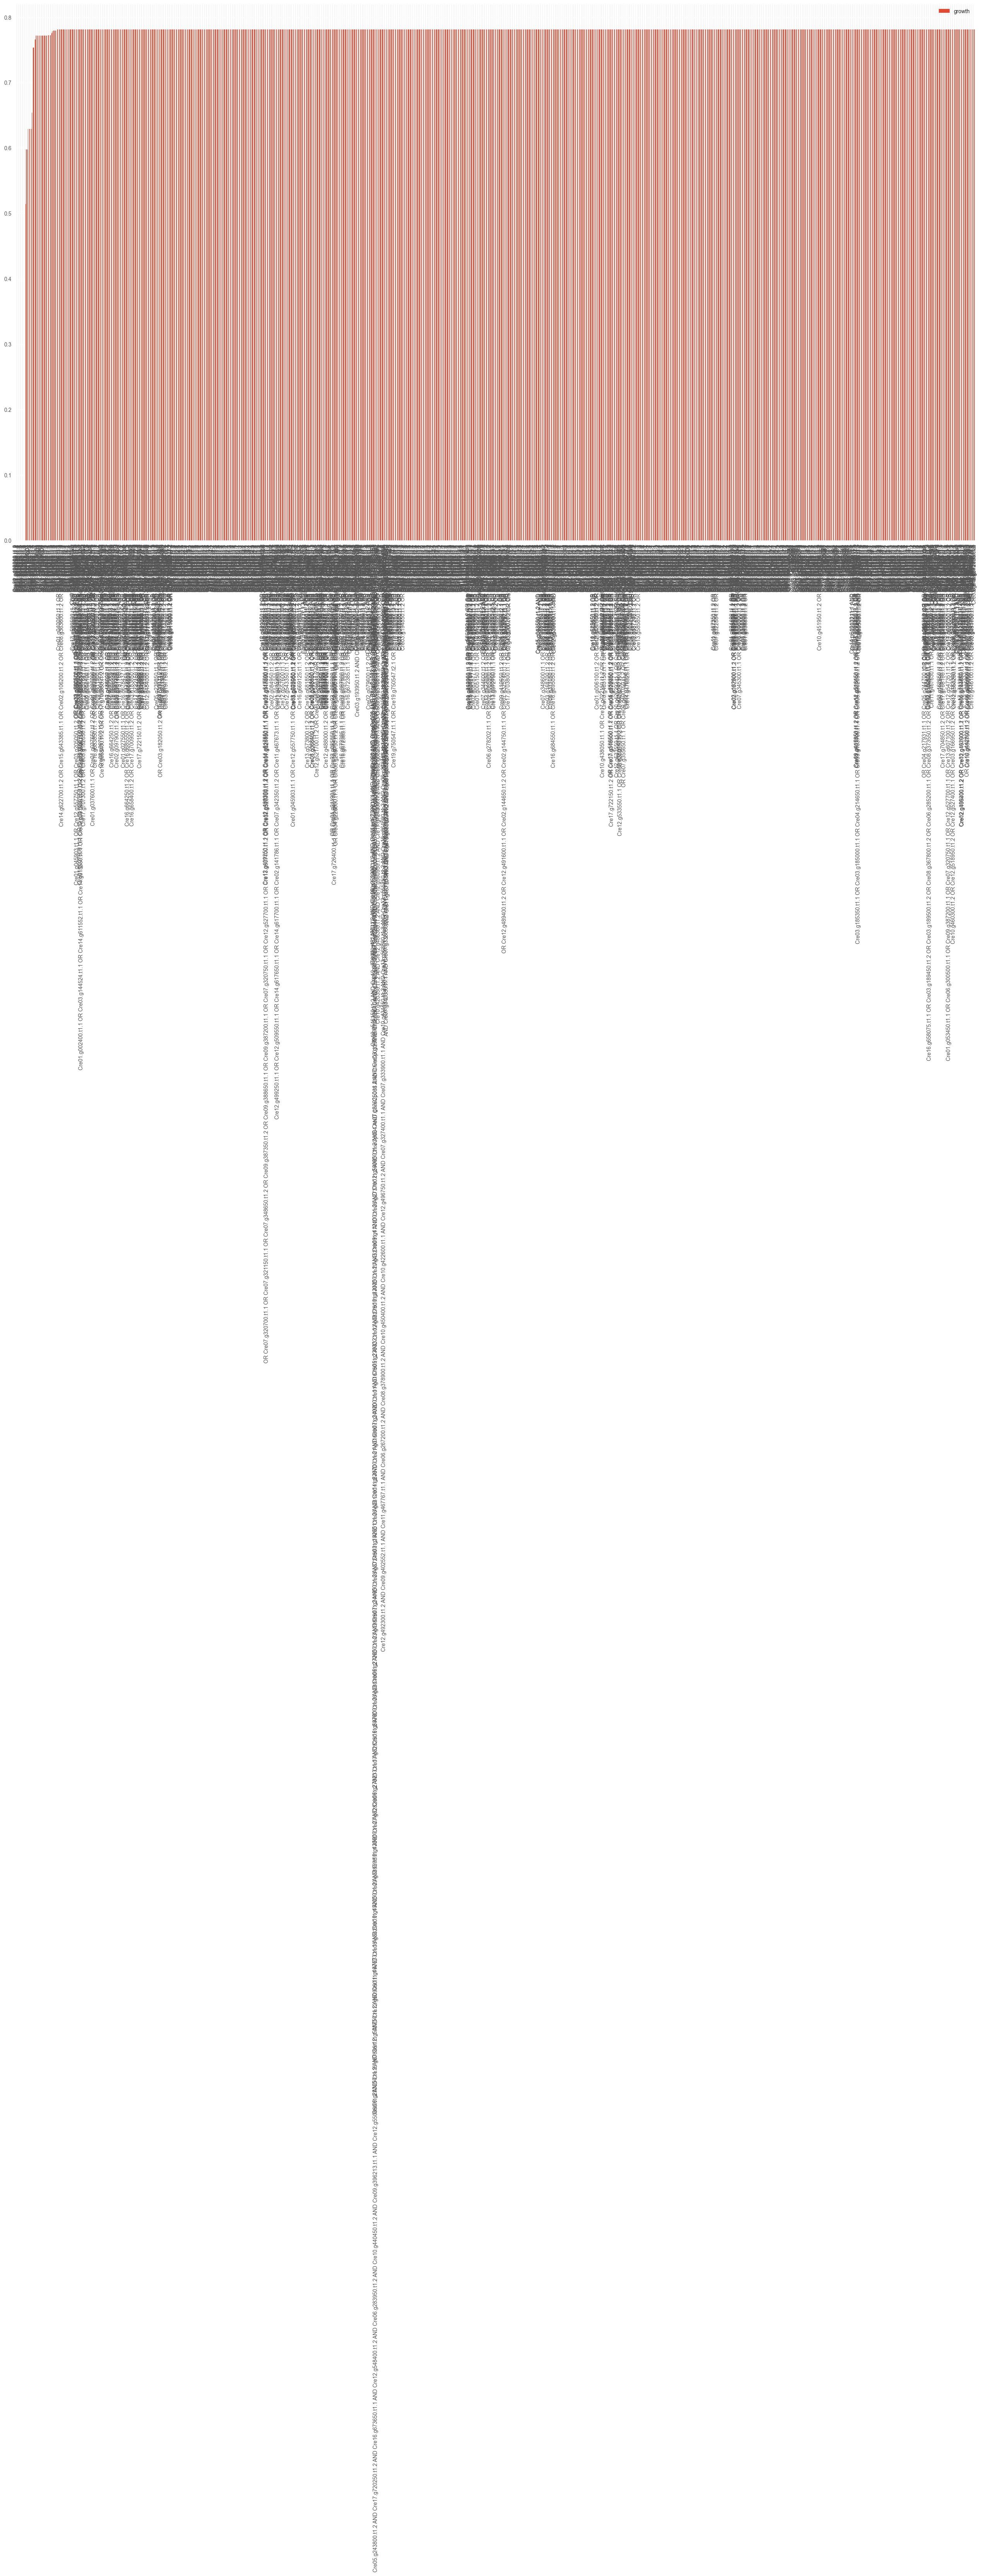

In [69]:
ax = df.plot.bar().axes
ax.figure.set_size_inches(32, 18)

In [62]:
from cameo.strain_design.heuristic.evolutionary_based import OptGene

ImportError: cannot import name 'find_gene_knockout_reactions' from 'cobra.manipulation.delete' (/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/cobra/manipulation/delete.py)

## Escher (unsuccessful attempt)

In [21]:
import escher

In [22]:
solution = model.optimize()

In [24]:
!wget -nc http://bigg.ucsd.edu/static/models/iRC1080.json

File ‘iRC1080.json’ already there; not retrieving.



In [ ]:
escher.Builder(map_json='iRC1080.json',
               reaction_data=solution.fluxes.to_dict(),model=model, highlight_missing=True).display_in_notebook()

In [ ]:
escher.list_available_maps()

[{'organism': 'Saccharomyces cerevisiae',
  'map_name': 'iMM904.Central carbon metabolism'},
 {'organism': 'Homo sapiens',
  'map_name': 'RECON1.Inositol retinol metabolism'},
 {'organism': 'Homo sapiens', 'map_name': 'RECON1.Glycolysis TCA PPP'},
 {'organism': 'Homo sapiens', 'map_name': 'RECON1.Tryptophan metabolism'},
 {'organism': 'Homo sapiens', 'map_name': 'RECON1.Carbohydrate metabolism'},
 {'organism': 'Homo sapiens',
  'map_name': 'RECON1.Amino acid metabolism (partial)'},
 {'organism': 'Escherichia coli', 'map_name': 'iJO1366.Nucleotide metabolism'},
 {'organism': 'Escherichia coli',
  'map_name': 'iJO1366.Fatty acid biosynthesis (saturated)'},
 {'organism': 'Escherichia coli',
  'map_name': 'iJO1366.Nucleotide and histidine biosynthesis'},
 {'organism': 'Escherichia coli', 'map_name': 'e_coli_core.Core metabolism'},
 {'organism': 'Escherichia coli', 'map_name': 'iJO1366.Central metabolism'},
 {'organism': 'Escherichia coli',
  'map_name': 'iJO1366.Fatty acid beta-oxidation'}

## Simulate batch cultivations using dynamic FBA (failed due to Error)

In [1]:
from os.path import dirname, join, pardir
from cobra.io import read_sbml_model
from dfba import DfbaModel, ExchangeFlux, KineticVariable

ModuleNotFoundError: No module named 'dfba'

# QUESTIONS

2. Calculate theoretical yields for other carbon sources?
3. Plot ppp for other conditions (e.g. anaerobic)?
4. Computationally enumerate all potential production pathways to your chosen product (even if it is a native product) and score them by different metrics (yield, number of steps added) - NOT APPLICABLE, right?
5. A \
X. Assess again model w/ modifications using MEMOTE \
X. Can't use escher with our organism I think...